In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor as RFR, HistGradientBoostingRegressor
from  sklearn.utils import resample
import scipy.stats as st
import math as m
from tqdm import tqdm
# from lightgbm import RandomForestRegres

In [5]:
data = pd.read_csv('insurance.csv', sep=',')
data_train = data.sample(frac=0.9)
data_validate = data.loc[~data.index.isin(data_train.index)]
data_train

,age,sex,bmi,children,smoker,region,charges
811,33,female,42.940,3,no,northwest,6360.99360
46,18,female,38.665,2,no,northeast,3393.35635
75,57,male,34.010,0,no,northwest,11356.66090
493,61,male,43.400,0,no,southwest,12574.04900
516,20,male,35.310,1,no,southeast,27724.28875
...,...,...,...,...,...,...,...
570,31,female,29.100,0,no,southwest,3761.29200
517,45,male,30.495,2,no,northwest,8413.46305
1334,18,female,31.920,0,no,northeast,2205.98080
523,38,female,37.730,0,no,southeast,5397.61670


# **L1 CONFIDENCE INTERVAL 95**

**CREATE COLUMN TRANSFORMER**

In [3]:
col_trans_l1 = ColumnTransformer([
    ('scaller', StandardScaler(), ['age', 'bmi', 'children']),
    ('hot_encode', OneHotEncoder(handle_unknown='ignore', drop='first'), ['sex', 'smoker', 'region']),
], remainder='passthrough')

**CREATE PIPE**

In [4]:
pipe_l1 = Pipeline([
    ('col_trans_l1', col_trans_l1), 
    ('poly', PolynomialFeatures(degree=4, include_bias=False)), 
    ('lasso', Lasso(alpha=69.56552173913043))
])

In [5]:
pipe_l1.fit(data_train.loc[:, ~data_train.columns.isin(['charges'])], data_train['charges'])

Pipeline(steps=[('col_trans_l1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaller', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('hot_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('poly', PolynomialFeatures(degree=4, include_bias=False)),
                ('lasso', Lasso(alpha=69.56552173913043))])

**L1 RESULTS- BEST MEAN SCORE**

In [6]:
def btstrap_cv_score(data, pipe):
    res = np.zeros((200,), dtype=int)
    for i in tqdm(range(200)):
        resampled_data = data.sample(frac=0.5)
        res[i] = -np.mean(cross_validate(pipe,
                                         resampled_data.loc[:, ~resampled_data.columns.isin(['charges'])],
                                         resampled_data['charges'],
                                         scoring=('neg_mean_absolute_error',))['test_neg_mean_absolute_error'])
    return res

In [7]:
l1_res = btstrap_cv_score(data_train, pipe_l1)

 33%|██████████████████████████▋                                                      | 66/200 [00:31<01:08,  1.94it/s]C:\Users\IvanZ\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.336e+06, tolerance: 6.807e+06
  model = cd_fast.enet_coordinate_descent(
 41%|█████████████████████████████████▏                                               | 82/200 [00:38<00:54,  2.15it/s]C:\Users\IvanZ\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.836e+06, tolerance: 6.812e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\IvanZ\anaconda3\lib\site-packages\sklearn\linear_

In [8]:
l1_res

array([2930, 2783, 3213, 2854, 2849, 3167, 3455, 2918, 2989, 3019, 3188,
       2854, 2663, 2907, 3326, 3199, 3332, 3126, 2890, 3317, 3008, 2934,
       3384, 2841, 3363, 3355, 3130, 2808, 2343, 2737, 3275, 3146, 2995,
       3306, 3178, 2891, 2870, 3073, 3114, 2828, 3230, 3266, 3000, 2845,
       2534, 2948, 2784, 3181, 2870, 3390, 2793, 2924, 2844, 2636, 3325,
       2989, 3239, 2848, 2849, 3300, 2777, 3244, 3115, 3576, 3098, 2748,
       3463, 3094, 2846, 2855, 3321, 3009, 2601, 3116, 2574, 3254, 3087,
       3191, 2652, 3463, 2801, 2718, 3144, 3411, 2746, 3470, 2951, 2857,
       3039, 3215, 2818, 2632, 2970, 3074, 2942, 3186, 3128, 3626, 3116,
       2748, 3132, 2965, 2853, 2899, 3089, 3111, 2884, 3017, 2869, 2793,
       2825, 3218, 2797, 2836, 2807, 2820, 3023, 2636, 3358, 2488, 2921,
       3055, 3087, 3103, 3091, 2981, 3234, 2858, 3091, 2683, 3177, 2958,
       3229, 3056, 2948, 3479, 2897, 2518, 2682, 2943, 3160, 3158, 2996,
       2932, 2646, 2838, 2966, 3141, 3000, 2969, 29

In [9]:
l1_res_df = pd.DataFrame(data=l1_res, columns=['means'])

In [10]:
print(np.mean(l1_res), np.std(l1_res, ddof=1), len(l1_res) ** 0.5)

3012.76 231.4831411207209 14.142135623730951


**CALCULATE 95% CONFIDENSE INTERVAL**

In [11]:
def conf_interv(array, conf_lvl):
    return (np.mean(array) - conf_lvl * (np.std(array, ddof=1) / m.sqrt(array.shape[0])), 
            np.mean(array) + conf_lvl * (np.std(array, ddof=1) / m.sqrt(array.shape[0])))

In [12]:
conf_interv(l1_res, 1.96)

(2980.6780734319027, 3044.8419265680977)

**BUILD HISTOGRAM**

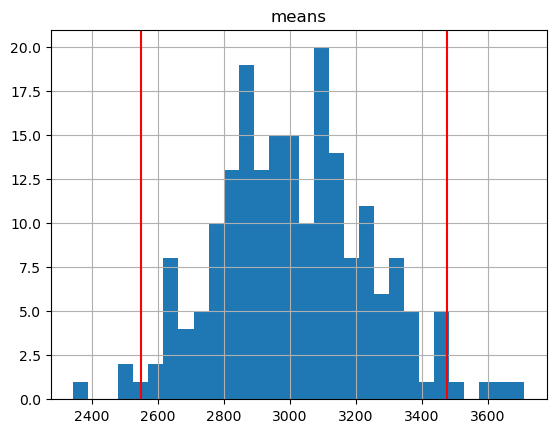

In [13]:
fig = l1_res_df.hist(bins=30)
fig[0][0].axvline(x=np.mean(l1_res) - 2 * np.std(l1_res, ddof=1), color='red')
fig[0][0].axvline(x=np.mean(l1_res) + 2 * np.std(l1_res, ddof=1), color='red')

**BUILD PROBABILITY DENSITY FUNCTION**

In [14]:
st.t.interval(alpha=0.95, df=len(l1_res)-1, loc=np.mean(l1_res), scale=st.sem(l1_res), )

C:\Users\IvanZ\AppData\Local\Temp\ipykernel_3300\1746027687.py:1: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  st.t.interval(alpha=0.95, df=len(l1_res)-1, loc=np.mean(l1_res), scale=st.sem(l1_res), )


(2980.482364771384, 3045.0376352286166)

# **L2 95 CONFIDENCE INTERVAL**

**LETS CREATE PIPE (WE CAN USE THE SAME COLUMN TRANSFORMER)**

In [15]:
col_trans_l2 = col_trans_l1

In [16]:
pipe_l2 = Pipeline([
    ('col_trans_l2', col_trans_l2), 
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    ('ridge', Ridge(alpha=1e-05))
])

**CALCULATE RESULTS**

In [17]:
l2_res = btstrap_cv_score(data_train, pipe_l2)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:22<00:00,  9.03it/s]


In [18]:
l2_res_df = pd.DataFrame(data=l2_res, columns=['means'])

In [19]:
st.t.interval(alpha=0.95, df=len(l2_res)-1, loc=np.mean(l2_res), scale=st.sem(l2_res))

C:\Users\IvanZ\AppData\Local\Temp\ipykernel_3300\1830565150.py:1: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  st.t.interval(alpha=0.95, df=len(l2_res)-1, loc=np.mean(l2_res), scale=st.sem(l2_res))


(2989.4384657488904, 3044.11153425111)

**BUILD HISTOGRAM**

array([[<AxesSubplot:title={'center':'means'}>]], dtype=object)

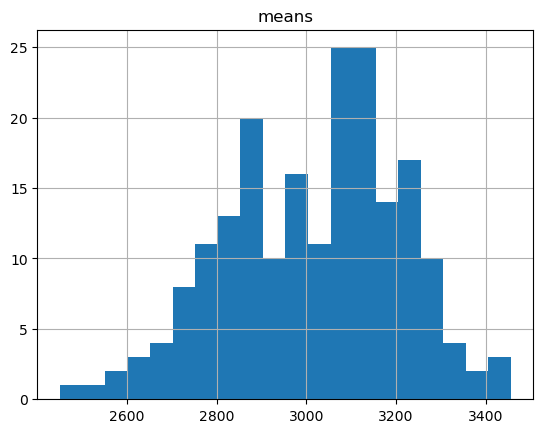

In [20]:
l2_res_df.hist(bins=20)

# **DECISION TREE BOOTSTRAP**

**CREATE COLLUMN TRANSFORMER**

In [21]:
bintree_trans = ColumnTransformer([
    ('encode_ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['sex', 'smoker', 'region']),
], remainder='passthrough')

**CREATE PIPELINE**

In [22]:
pipe_bintree = Pipeline([
    ('bintree_trans', bintree_trans), 
    ('bintree', DecisionTreeRegressor(max_depth=5, min_samples_leaf=11))
])

**CALCULATE RESULTS**

In [23]:
bintree_res = btstrap_cv_score(data_train, pipe_bintree)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.04it/s]


In [24]:
bintree_res

array([2985, 2623, 2826, 2591, 2732, 2999, 2828, 2564, 2611, 2748, 2605,
       2520, 2676, 2514, 2866, 2759, 2630, 2844, 3021, 2858, 2886, 2841,
       2853, 2592, 2699, 2844, 3198, 2791, 2831, 2696, 2766, 2771, 2742,
       2818, 2588, 2791, 2770, 2635, 2580, 3056, 2559, 2733, 2788, 2818,
       2533, 2461, 2790, 3048, 2602, 2525, 2728, 2816, 2882, 2579, 2438,
       2488, 2664, 2982, 2783, 2680, 2750, 2839, 2937, 2882, 2661, 2868,
       2691, 2861, 2839, 2686, 2900, 2537, 2754, 2784, 2937, 2645, 2645,
       2730, 2677, 2885, 2862, 2737, 2841, 2948, 2982, 3103, 3449, 3169,
       3229, 2941, 2668, 2795, 2759, 2694, 2718, 2894, 2715, 2955, 2679,
       2519, 2796, 2839, 2823, 2720, 2771, 2821, 2397, 2932, 2769, 2758,
       2849, 2618, 2939, 2595, 3079, 3070, 2612, 2519, 2592, 2718, 2630,
       2949, 3358, 2619, 3132, 2848, 2687, 2587, 2560, 2662, 2697, 2670,
       2905, 2567, 2747, 2843, 2956, 2874, 2599, 2939, 2782, 2871, 2617,
       2854, 2812, 2648, 3042, 2837, 2918, 2592, 26

In [25]:
bintree_df = pd.DataFrame(data=bintree_res, columns=['means'])

**BUILD HISTOGRAM**

array([[<AxesSubplot:title={'center':'means'}>]], dtype=object)

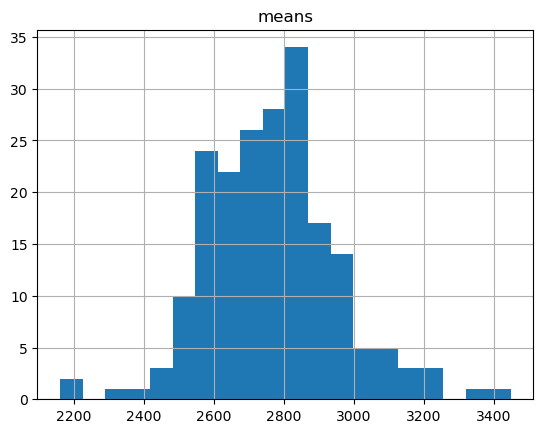

In [26]:
bintree_df.hist(bins=20)

In [27]:
st.t.interval(alpha=0.95, df=len(bintree_res)-1, loc=np.mean(bintree_res), scale=st.sem(bintree_res), )

C:\Users\IvanZ\AppData\Local\Temp\ipykernel_3300\2307373638.py:1: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  st.t.interval(alpha=0.95, df=len(bintree_res)-1, loc=np.mean(bintree_res), scale=st.sem(bintree_res), )


(2740.6125391835826, 2792.4674608164173)

In [41]:
boost = [Pipeline([
    ('bintree_trans', bintree_trans), 
    ('bintree', DecisionTreeRegressor(splitter='random', max_features=4))
]) for i in range(100)]

In [42]:
objective = data_train['charges'].copy(deep=True)
for tree in boost:
    tree.fit(data_train.loc[:, ~data_train.columns.isin(['charges'])], objective)
    temp_res = tree.predict(data_train.loc[:, ~data_train.columns.isin(['charges'])])
    objective -= 0.01 * temp_res

In [43]:
mae(data_train['charges'], objective)

8226.872504239976

In [7]:
model = HistGradientBoostingRegressor(learning_rate=0.01, loss='absolute_error', categorical_features= ['sex', 'smoker', 'region'])

In [8]:
model.fit(data_train.loc[:, ~data_train.columns.isin(['charges'])], data_train['charges'])

ValueError: could not convert string to float: 'female'